# K-Nearest Neighbors (KNN)

#### by Chiyuan Zhang and S&ouml;ren Sonnenburg

This notebook illustrates the <a href="http://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm">K-Nearest Neighbors</a> (KNN) algorithm on the USPS digit recognition dataset in Shogun. Further, the effect of <a href="http://en.wikipedia.org/wiki/Cover_tree">Cover Trees</a> on speed is illustrated by comparing KNN with and without it. Finally, a comparison with <a href="http://en.wikipedia.org/wiki/Support_vector_machine#Multiclass_SVM">Multiclass Support Vector Machines</a> is shown. 

## The basics

The training of a KNN model basically does nothing but memorizing all the training points and the associated labels, which is very cheap in computation but costly in storage. The prediction is implemented by finding the K nearest neighbors of the query point, and voting. Here K is a hyper-parameter for the algorithm. Smaller values for K give the model low bias but high variance; while larger values for K give low variance but high bias.

In `SHOGUN`, you can use [KNN](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KNN.html) to perform KNN learning. To construct a KNN machine, you must choose the hyper-parameter K and a distance function. Usually, we simply use the standard  [EuclideanDistance](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1EuclideanDistance.html), but in general, any subclass of [Distance](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1Distance.html) could be used. For demonstration, in this tutorial we select a random subset of 1000 samples from the USPS digit recognition dataset, and run 2-fold cross validation of KNN with varying K.

First we load and init data split:

In [8]:
import numpy as np
import os
SHOGUN_DATA_DIR=os.getenv('SHOGUN_DATA_DIR', '../../../data')

from scipy.io import loadmat, savemat
from numpy    import random
from os       import path
import matplotlib.pyplot as plt
%matplotlib inline

import shogun as sg


mat  = loadmat(os.path.join(SHOGUN_DATA_DIR, 'multiclass/usps.mat'))
Xall = mat['data']
Yall = np.array(mat['label'].squeeze(), dtype=np.double)

# map from 1..10 to 0..9, since shogun
# requires multiclass labels to be
# 0, 1, ..., K-1
Yall = Yall - 1

random.seed(0)

subset = random.permutation(len(Yall))

Xtrain = Xall[:, subset[:5000]]
Ytrain = Yall[subset[:5000]]

Xtest = Xall[:, subset[5000:6000]]
Ytest = Yall[subset[5000:6000]]

Nsplit = 2
all_ks = range(1, 21)

print(Xall.shape)
print(Xtrain.shape)
print(Xtest.shape)

(256, 9298)
(256, 5000)
(256, 1000)


Let us plot the first five examples of the train data (first row) and test data (second row).

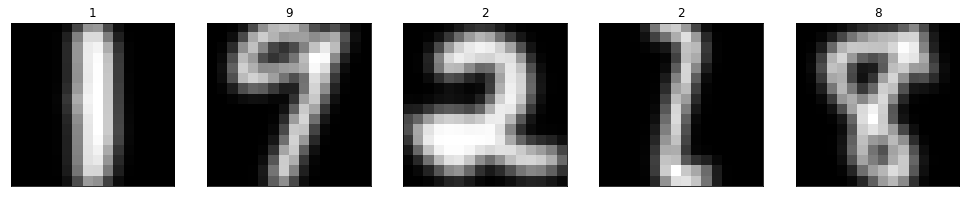

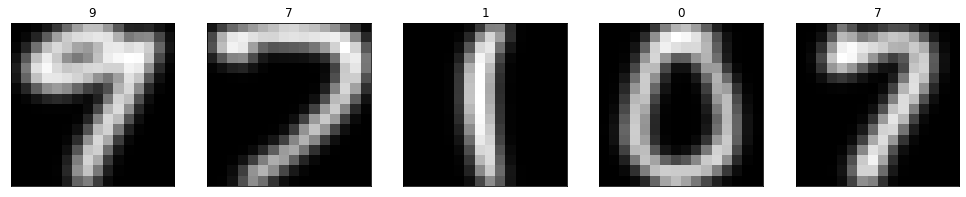

In [9]:
def plot_example(dat, lab):
    for i in range(5):
        ax=plt.subplot(1,5,i+1)
        plt.title(int(lab[i]))
        ax.imshow(dat[:,i].reshape((16,16)), interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
        
        
_=plt.figure(figsize=(17,6))
plt.gray()
plot_example(Xtrain, Ytrain)

_=plt.figure(figsize=(17,6))
plt.gray()
plot_example(Xtest, Ytest)

Then we import shogun components and convert the data to shogun objects:

In [10]:
labels = sg.create_labels(Ytrain)
feats  = sg.create_features(Xtrain)
k=3
dist = sg.create_distance('EuclideanDistance')
knn = sg.create_machine("KNN", k=k, distance=dist, labels=labels)
labels_test = sg.create_labels(Ytest)
feats_test  = sg.create_features(Xtest)
knn.train(feats)
pred = knn.apply(feats_test)
print("Predictions", pred.get("labels")[:5])
print("Ground Truth", Ytest[:5])

evaluator = sg.create_evaluation("MulticlassAccuracy")
accuracy = evaluator.evaluate(pred, labels_test)

print("Accuracy = %2.2f%%" % (100*accuracy))

Predictions [9. 7. 1. 0. 7.]
Ground Truth [9. 7. 1. 0. 7.]
Accuracy = 97.30%


Let's plot a few missclassified examples - I guess we all agree that these are notably harder to detect.

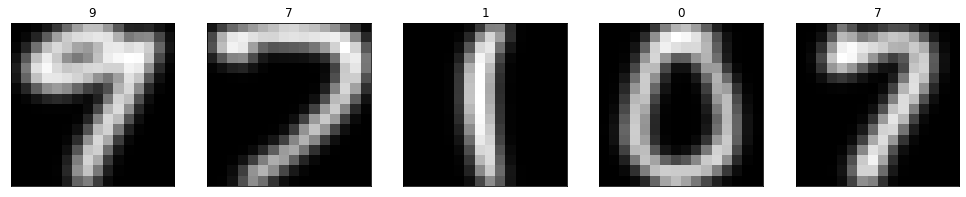

In [11]:
idx=np.where(pred != Ytest)[0]
Xbad=Xtest[:,idx]
Ybad=Ytest[idx]
_=plt.figure(figsize=(17,6))
plt.gray()
plot_example(Xbad, Ybad)

Now the question is - is 97.30% accuracy the best we can do? While one would usually re-train KNN with different values for k here and likely perform Cross-validation, we just use a small trick here that saves us lots of computation time: When we have to determine the $K\geq k$ nearest neighbors we will know the nearest neigbors for all $k=1...K$ and can thus get the predictions for multiple k's in one step:

In [12]:
knn.put('k', 13)
multiple_k=knn.get("classify_for_multiple_k")
print(multiple_k.shape)

(1000, 13)


We have the prediction for each of the 13 k's now and can quickly compute the accuracies:

In [13]:
for k in range(13):
    print("Accuracy for k=%d is %2.2f%%" % (k+1, 100*np.mean(multiple_k[:,k]==Ytest)))

Accuracy for k=1 is 97.20%
Accuracy for k=2 is 97.20%
Accuracy for k=3 is 97.30%
Accuracy for k=4 is 96.70%
Accuracy for k=5 is 96.70%
Accuracy for k=6 is 96.60%
Accuracy for k=7 is 96.40%
Accuracy for k=8 is 96.50%
Accuracy for k=9 is 96.20%
Accuracy for k=10 is 96.20%
Accuracy for k=11 is 96.00%
Accuracy for k=12 is 96.30%
Accuracy for k=13 is 96.20%


So k=3 seems to have been the optimal choice.

## Accellerating KNN

Obviously applying KNN is very costly: for each prediction you have to compare the object against all training objects. While the implementation in `SHOGUN` will use all available CPU cores to parallelize this computation it might still be slow when you have big data sets. In `SHOGUN`, you can use *Cover Trees* to speed up the nearest neighbor searching process in KNN. Just call `set_use_covertree` on the KNN machine to enable or disable this feature. We also show the prediction time comparison with and without Cover Tree in this tutorial. So let's just have a comparison utilizing the data above:

In [14]:
%%time
knn.put('k', 3)
knn.put('knn_solver', "KNN_BRUTE")
pred = knn.apply(feats_test)

CPU times: user 6.01 s, sys: 3.79 ms, total: 6.01 s
Wall time: 3.03 s


In [ ]:
# FIXME: causes SEGFAULT
# %%time
# knn.put('k', 3)
# knn.put('knn_solver', "KNN_COVER_TREE")
# pred = knn.apply(feats_test)

So we can significantly speed it up. Let's do a more systematic comparison. For that a helper function is defined to run the evaluation for KNN:

In [15]:
def evaluate(labels, feats, use_cover_tree=False):
    import time
    split = sg.create_splitting_strategy("CrossValidationSplitting", labels=labels, num_subsets=Nsplit)
    split.build_subsets()
    
    accuracy = np.zeros((Nsplit, len(all_ks)))
    acc_train = np.zeros(accuracy.shape)
    time_test = np.zeros(accuracy.shape)
    for i in range(Nsplit):
        idx_train = split.generate_subset_inverse(i)
        idx_test  = split.generate_subset_indices(i)

        for j, k in enumerate(all_ks):
            #print "Round %d for k=%d..." % (i, k)

            feats.add_subset(idx_train)
            labels.add_subset(idx_train)

            dist = sg.create_distance('EuclideanDistance')
            knn = sg.create_machine("KNN", k=k, distance=dist)
            #knn.set_store_model_features(True)
            #FIXME: causes SEGFAULT
            if use_cover_tree:
                continue
            #    knn.put('knn_solver', "KNN_COVER_TREE")
            else:
                knn.put('knn_solver', "KNN_BRUTE")
            knn.train(feats, labels)

            evaluator = sg.create_evaluation("MulticlassAccuracy")
            pred = knn.apply(feats)
            acc_train[i, j] = evaluator.evaluate(pred, labels)

            feats.remove_subset()
            labels.remove_subset()
            feats.add_subset(idx_test)
            labels.add_subset(idx_test)

            t_start = time.clock()
            pred = knn.apply_multiclass(feats)
            time_test[i, j] = (time.clock() - t_start) / labels.get_num_labels()

            accuracy[i, j] = evaluator.evaluate(pred, labels)

            feats.remove_subset()
            labels.remove_subset()
    return {'eout': accuracy, 'ein': acc_train, 'time': time_test}

Evaluate KNN with and without Cover Tree. This takes a few seconds:

In [16]:
labels = sg.create_labels(Ytest)
feats  = sg.create_features(Xtest)
print("Evaluating KNN...")
wo_ct = evaluate(labels, feats, use_cover_tree=False)
# wi_ct = evaluate(labels, feats, use_cover_tree=True)
print("Done!")

Evaluating KNN...
Done!


Generate plots with the data collected in the evaluation:

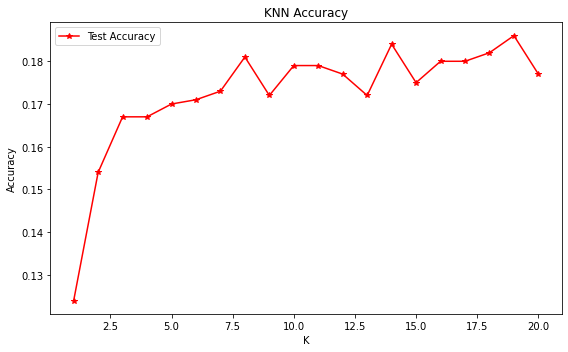

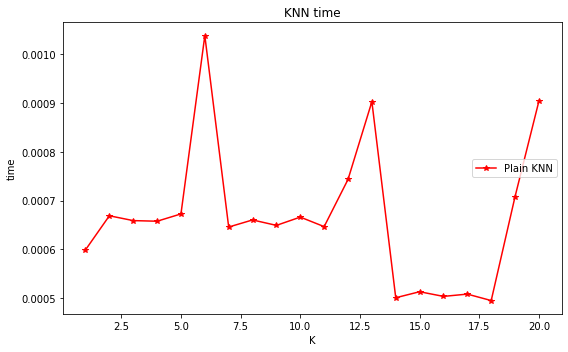

In [17]:
fig = plt.figure(figsize=(8,5))
plt.plot(all_ks, wo_ct['eout'].mean(axis=0), 'r-*')
# plt.plot(all_ks, wo_ct['ein'].mean(axis=0), 'r--*')
plt.legend(["Test Accuracy", "Training Accuracy"])
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy')
plt.tight_layout()

fig = plt.figure(figsize=(8,5))
plt.plot(all_ks, wo_ct['time'].mean(axis=0), 'r-*')
# plt.plot(all_ks, wi_ct['time'].mean(axis=0), 'b-d')
plt.xlabel("K")
plt.ylabel("time")
plt.title('KNN time')
plt.legend(["Plain KNN", "CoverTree KNN"], loc='center right')
plt.tight_layout()

Although simple and elegant, KNN is generally very resource costly. Because all the training samples are to be memorized literally, the memory cost of KNN *learning* becomes prohibitive when the dataset is huge. Even when the memory is big enough to hold all the data, the prediction will be slow, since the distances between the query point and all the training points need to be computed and ranked. The situation becomes worse if in addition the data samples are all very high-dimensional. Leaving aside computation time issues, k-NN is a very versatile and competitive algorithm. It can be applied to any kind of objects (not just numerical data) - as long as one can design a suitable distance function. In pratice k-NN used with bagging can create improved and more robust results.

## Comparison to Multiclass Support Vector Machines

In contrast to KNN - multiclass Support Vector Machines (SVMs) attempt to model the decision function separating each class from one another. They compare examples utilizing similarity measures (so called Kernels) instead of distances like KNN does. When applied, they are in Big-O notation computationally as expensive as KNN but involve another (costly) training step. They do not scale very well to cases with a huge number of classes but usually lead to favorable results when applied to small number of classes cases. So for reference let us compare how a standard multiclass SVM performs wrt. KNN on the mnist data set from above.

Let us first train a multiclass svm using a Gaussian kernel (kind of the SVM equivalent to the euclidean distance).

In [18]:
width=80
C=1

gk=sg.create_kernel("GaussianKernel", log_width=np.log(width))

svm=sg.create_machine("GMNPSVM", C=C, kernel=gk, labels=labels)
_=svm.train(feats)

Let's apply the SVM to the same test data set to compare results:

In [19]:
out=svm.apply(feats_test)
evaluator = sg.create_evaluation("MulticlassAccuracy")
accuracy = evaluator.evaluate(out, labels_test)

print("Accuracy = %2.2f%%" % (100*accuracy))

Accuracy = 92.60%


Since the SVM performs way better on this task - let's apply it to all data we did not use in training.

Accuracy = 89.02%


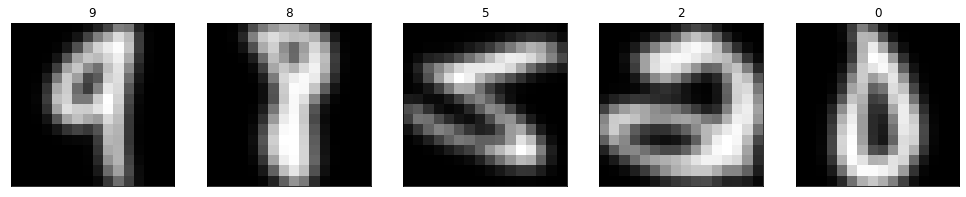

In [20]:
Xrem=Xall[:,subset[6000:]]
Yrem=Yall[subset[6000:]]

feats_rem=sg.create_features(Xrem)
labels_rem=sg.create_labels(Yrem)
out=svm.apply(feats_rem)

evaluator = sg.create_evaluation("MulticlassAccuracy")
accuracy = evaluator.evaluate(out, labels_rem)

print("Accuracy = %2.2f%%" % (100*accuracy))

idx=np.where(out.get("labels") != Yrem)[0]
Xbad=Xrem[:,idx]
Ybad=Yrem[idx]
_=plt.figure(figsize=(17,6))
plt.gray()
plot_example(Xbad, Ybad)

The misclassified examples are indeed much harder to label even for human beings.